# Prep my data for offline flux calculation

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt

import aerobulk

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
kwargs = dict(consolidated=True, use_cftime=True, engine="zarr")
    
print("Load Data")
ocean_path = "gs://cmip6/GFDL_CM2_6/control/surface"
ds_ocean = xr.open_dataset(fs.get_mapper(ocean_path), chunks={"time": 3}, **kwargs)

Load Data


In [5]:
ocean_boundary_path = "gs://cmip6/GFDL_CM2_6/control/ocean_boundary"
ds_ocean_boundary = xr.open_dataset(fs.get_mapper(ocean_boundary_path), chunks={"time": 3}, **kwargs)

In [6]:
grid_path = "gs://cmip6/GFDL_CM2_6/grid"
ds_ocean_grid = xr.open_dataset(fs.get_mapper(grid_path), chunks={}, **kwargs)

In [7]:
# combine all dataset on the ocean grid together
ds_ocean = xr.merge([ds_ocean_grid, ds_ocean, ds_ocean_boundary], compat='override')
ds_ocean

<xarray.Dataset> Size: 12TB
Dimensions:                    (yt_ocean: 2700, xt_ocean: 3600, yu_ocean: 2700,
                                xu_ocean: 3600, st_edges_ocean: 51,
                                st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50,
                                nv: 2, st_ocean_sub01: 1, time: 7400)
Coordinates: (12/30)
    area_t                     (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_u                     (yu_ocean, xu_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt                        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxu                        (yu_ocean, xu_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt                        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyu                        (yu_ocean, xu_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...                         ...
  * xu_ocean                   (xu_ocean) float64 29kB -279.9 -279.8 ... 80.0
  * yt_ocean                   (yt_ocean) float64 22kB -81.11 -81.07 ... 89.98
  * yu_ocean                   (yu_ocean) float64 22kB -81.09 -81.05 ... 90.0
  * nv                         (nv) float64 16B 1.0 2.0
  * st_ocean_sub01             (st_ocean_sub01) float64 8B 5.034
  * time                       (time) object 59kB 0181-01-01 12:00:00 ... 020...
Data variables: (12/41)
    biomass_p                  (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    chl                        (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    dic                        (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    htotal                     (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    irr_mix                    (time, st_ocean_sub01, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 1, 2700, 3600), meta=np.ndarray>
    kw                         (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
Attributes:
    NCO:      4.0.3

In [8]:
print("Interpolating ocean velocities")
# interpolate ocean velocities onto the tracer points using xgcm
from xgcm import Grid

# add xgcm comodo attrs
ds_ocean["xu_ocean"].attrs["axis"] = "X"
ds_ocean["xt_ocean"].attrs["axis"] = "X"
ds_ocean["xu_ocean"].attrs["c_grid_axis_shift"] = 0.5
ds_ocean["xt_ocean"].attrs["c_grid_axis_shift"] = 0.0
ds_ocean["yu_ocean"].attrs["axis"] = "Y"
ds_ocean["yt_ocean"].attrs["axis"] = "Y"
ds_ocean["yu_ocean"].attrs["c_grid_axis_shift"] = 0.5
ds_ocean["yt_ocean"].attrs["c_grid_axis_shift"] = 0.0
grid = Grid(ds_ocean)

Interpolating ocean velocities


In [9]:
# fill missing values with 0, then interpolate.
tracer_ref = ds_ocean["surface_temp"]
sst_wet_mask = ~np.isnan(tracer_ref)

ds_ocean["u_ocean"] = grid.interp_like(
    ds_ocean["usurf"].fillna(0), tracer_ref
).where(sst_wet_mask)
ds_ocean["v_ocean"] = grid.interp_like(
    ds_ocean["vsurf"].fillna(0), tracer_ref
).where(sst_wet_mask)

In [10]:
# xarray says not to do this
# ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs) # noqa: E501
atmos_path = "gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr"
ds_atmos = xr.open_dataset(fs.get_mapper(atmos_path), chunks={"time": 120}, **kwargs).chunk(
    {"time": 3}
)

In [11]:
# rename the atmos data coordinates only to CESM conventions
ds_atmos = ds_atmos.rename({'grid_xt':'lon', 'grid_yt':'lat'})

In [12]:
print("Modify units")
ds_ocean["surface_temp"] = ds_ocean["surface_temp"] + 273.15
ds_atmos["slp"] = ds_atmos["slp"] * 100  # TODO: Double check this
ds_atmos

Modify units


<xarray.Dataset> Size: 1TB
Dimensions:       (time: 29586, lat: 360, lon: 576, bnds: 2)
Coordinates:
  * lon           (lon) float64 5kB 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
  * lat           (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time          (time) object 237kB 0120-01-01 12:00:00 ... 0200-12-31 12:0...
Dimensions without coordinates: bnds
Data variables: (12/47)
    WVP           (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] 237kB dask.array<chunksize=(3,), meta=np.ndarray>
    average_T1    (time) object 237kB dask.array<chunksize=(3,), meta=np.ndarray>
    average_T2    (time) object 237kB dask.array<chunksize=(3,), meta=np.ndarray>
    evap          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    grid_xt_bnds  (lon, bnds) float64 9kB dask.array<chunksize=(576, 2), meta=np.ndarray>
    ...            ...
    v500          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    v700          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    v850          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    v_ref         (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    wind          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    wind_max      (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
Attributes:
    code_version:  $Name: fre-nctools-bronx-10 $
    filename:      01200101.atmos_daily.tile1.nc
    grid_tile:     N/A
    grid_type:     regular
    history:       fregrid --input_mosaic /ptmp/rds/WGA/MOSAIC/C180_mosaic.nc...
    title:         CM2.6_miniBling

## Merge atmos and ocean data

In [13]:
def load_and_combine_cm26(
    filesystem: gcsfs.GCSFileSystem, inline_array=False
) -> xr.Dataset:
    """Loads, combines, and preprocesses CM2.6 data
    Steps:
    - Interpolate ocean velocities on ocean tracer points (with xgcm)
    - Regrid atmospheric variables to ocean tracer grid (with xesmf)
    - Match time and merge datasets
    - Adjust units for aerobulk input
    - Calculate relative wind components
    """
    kwargs = dict(
        consolidated=True, use_cftime=True, inline_array=inline_array, engine="zarr"
    )
    print("Load Data")
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/surface")
    ds_ocean = xr.open_dataset(mapper, chunks={"time": 3}, **kwargs)
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/ocean_boundary")
    xr.open_dataset(mapper, chunks={"time": 3}, **kwargs)

    # xarray says not to do this
    # ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs) # noqa: E501
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr")
    ds_atmos = xr.open_dataset(mapper, chunks={"time": 120}, **kwargs).chunk(
        {"time": 3}
    )
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/grid")
    ds_oc_grid = xr.open_dataset(mapper, chunks={}, **kwargs)
    # ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()

    print("Align in time")
    # cut to same time
    all_dims = set(list(ds_ocean.dims) + list(ds_atmos.dims))
    ds_ocean, ds_atmos = xr.align(
        ds_ocean,
        ds_atmos,
        join="inner",
        exclude=(di for di in all_dims if di != "time"),
    )

    print("Interpolating ocean velocities")
    # interpolate ocean velocities onto the tracer points using xgcm
    from xgcm import Grid

    # add xgcm comodo attrs
    ds_ocean["xu_ocean"].attrs["axis"] = "X"
    ds_ocean["xt_ocean"].attrs["axis"] = "X"
    ds_ocean["xu_ocean"].attrs["c_grid_axis_shift"] = 0.5
    ds_ocean["xt_ocean"].attrs["c_grid_axis_shift"] = 0.0
    ds_ocean["yu_ocean"].attrs["axis"] = "Y"
    ds_ocean["yt_ocean"].attrs["axis"] = "Y"
    ds_ocean["yu_ocean"].attrs["c_grid_axis_shift"] = 0.5
    ds_ocean["yt_ocean"].attrs["c_grid_axis_shift"] = 0.0
    grid = Grid(ds_ocean)
    # fill missing values with 0, then interpolate.
    sst_wet_mask = ~np.isnan(ds_ocean["surface_temp"])
    # TODO: Maybe stencil out the nans from SST? This is done again in aerobulk-python
    ds_ocean["u_ocean"] = grid.interp_like(
        ds_ocean["usurf"].fillna(0), ds_ocean["surface_temp"]
    ).where(sst_wet_mask)
    ds_ocean["v_ocean"] = grid.interp_like(
        ds_ocean["vsurf"].fillna(0), ds_ocean["surface_temp"]
    ).where(sst_wet_mask)
    # FIXME: All of these additional operations (filling/masking) add lot more tasks...

    print("Regrid Atmospheric Data")
    # Start regridding the atmosphere onto the ocean grid
    # Load precalculated regridder weights from group bucket
    # TODO: Maybe this should be an input argument?
    path = "gs://leap-persistent/jbusecke/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr"  # noqa: E501
    mapper = filesystem.get_mapper(path)
    ds_regridder = xr.open_zarr(mapper).load()
    regridder = xe.Regridder(
        ds_atmos.olr.to_dataset(name="dummy")
        .isel(time=0)
        .reset_coords(drop=True),  # this is the same dumb problem I keep having with
        ds_ocean.surface_temp.to_dataset(name="dummy")
        .isel(time=0)
        .reset_coords(drop=True),
        "bilinear",
        weights=ds_regridder,
        periodic=True,
    )
    ds_atmos_regridded = regridder(
        ds_atmos[["slp", "v_ref", "u_ref", "t_ref", "q_ref", "wind"]]
    )  # We are only doing noskin for now , 'swdn_sfc', 'lwdn_sfc'

    ## combine into merged dataset
    ds_merged = xr.merge(
        [
            ds_atmos_regridded,
            ds_ocean[["surface_temp", "u_ocean", "v_ocean"]],
        ]
    )
    print("Modify units")
    # ds_merged = ds_merged.transpose(
    #     'xt_ocean', 'yt_ocean', 'time'
    # )
    # fix units for aerobulk
    ds_merged["surface_temp"] = ds_merged["surface_temp"] + 273.15
    ds_merged["slp"] = ds_merged["slp"] * 100  # check this

    print("Mask nans")
    # atmos missing values are filled with 0s, which causes issues with the filtering
    # Ideally this should be masked before the regridding, but xesmf fills with 0 again...
    mask = ~np.isnan(ds_merged['surface_temp'].isel(time=0).reset_coords(drop=True))
    for mask_var in ['slp', 't_ref', 'q_ref', 'v_ref', 'u_ref', 'wind']:
        ds_merged[mask_var] = ds_merged[mask_var].where(mask)
    
    
    # also apply this mask to certain coordinates from the grid dataset (for now only tracer_area since that 
    for mask_coord in ['area_t']:
        ds_merged.coords[mask_coord] = ds_oc_grid[mask_coord].where(mask,0.0).astype(np.float64)
    # The casting to float64 is needed to avoid that weird bug where the manual global weighted ave
    # is not close to the xarray weighted mean (I was not able to reproduce this with an example)
    
    # Ideally this should be masked before the regridding,
    # but xesmf fills with 0 again...
    mask = ~np.isnan(ds_merged["surface_temp"])
    for mask_var in ["slp", "t_ref", "q_ref"]:
        ds_merged[mask_var] = ds_merged[mask_var].where(mask)

    # Calculate relative wind
    print("Calculate relative wind")
    ds_merged["u_relative"] = ds_merged["u_ref"] - ds_merged["u_ocean"]
    ds_merged["v_relative"] = ds_merged["v_ref"] - ds_merged["v_ocean"]

    return ds_merged

In [14]:
ds_merged  = load_and_combine_cm26(fs, inline_array=True)
ds_merged

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## GCM Filtering -- some useful functions

In [15]:
import gcsfs
import gcm_filters

def filter_inputs_dataset(
    ds: xr.Dataset,
    dims: list,
    filter_scale: int,
    timedim: str = "time",
    filter_type: str = "taper",
) -> xr.Dataset:
    """Wrapper that filters a whole dataset, generating a wet_mask from
    the nanmask of the first timestep (if time is present)."""
    ds_out = xr.Dataset()

    # create a wet mask that only allows values which are 'wet' in all variables

    wet_masks = []
    for var in ds.data_vars:
        da = ds[var]
        if timedim in da.dims:
            mask_da = da.isel({timedim: 0})
        else:
            mask_da = da
        wet_masks.append((~np.isnan(mask_da)))

    combined_wet_mask = xr.concat(wet_masks, dim="var").all("var").astype(int)

    for var in ds.data_vars:
        ds_out[var] = filter_inputs(
            ds[var], combined_wet_mask, dims, filter_scale, filter_type=filter_type
        )

    ds_out.attrs["filter_scale"] = filter_scale
    ds_out.attrs["filter_type"] = filter_type
    return ds_out

def filter_inputs(
    da: xr.DataArray,
    wet_mask: xr.DataArray,
    dims: list,
    filter_scale: int,
    filter_type: str = "taper",
) -> xr.DataArray:
    """filters input using gcm-filters"""
    if filter_type == "gaussian":
        input_filter = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=1,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
            grid_vars={"wet_mask": wet_mask},
        )
    elif filter_type == "taper":
        # transition_width = np.pi/2
        transition_width = np.pi
        input_filter = gcm_filters.Filter(
            filter_scale=filter_scale,
            transition_width=transition_width,
            dx_min=1,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
            grid_vars={"wet_mask": wet_mask},
        )
    elif filter_type == "tripolar_pop":
        input_filter = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=1,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED,
            grid_vars={"area":da.TAREA,"wet_mask": wet_mask},
        )

    else:
        raise ValueError(
            f"`filter_type` needs to be `gaussian` or `taper', got {filter_type}"
        )
    out = input_filter.apply(da, dims=dims)
    out.attrs["filter_scale"] = filter_scale
    out.attrs["filter_type"] = filter_type
    return out


## Filtering with gcm filters

In [16]:
ds_in = ds_merged
ds_in = ds_in.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

print("Filtering model")
ds_out = filter_inputs_dataset(ds_in, ['yt_ocean', 'xt_ocean'], filter_scale=4, filter_type='taper')

ds_lowRes = ds_out
ds_highRes = ds_in

Filtering model


### Heat flux

Filtering model
Filtering model


Text(0.5, 1.0, 'Q* Heat Flux from AeroBulk')

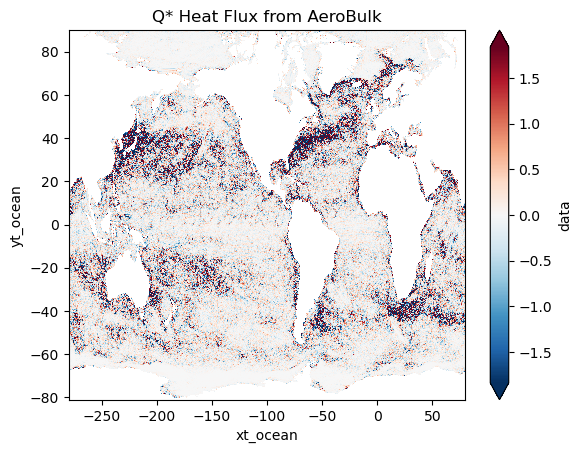

In [17]:
from aerobulk import noskin

ql, qh, taux, tauy, evap =  noskin(
        ds_highRes.surface_temp,
        ds_highRes.t_ref,
        ds_highRes.q_ref,
        ds_highRes.u_relative,
        ds_highRes.v_relative,
        slp=ds_highRes.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatfluxHR = qh + ql
heatfluxHR_DS = heatfluxHR.to_dataset(name='data')

print("Filtering model")
heatfluxHR_smooth = filter_inputs_dataset(heatfluxHR_DS, ['yt_ocean', 'xt_ocean'], filter_scale=4, filter_type='taper')

heatfluxHR_smooth_DA = heatfluxHR_smooth['data']

ql_LR, qh_LR, taux_LR, tauy_LR, evap_LR =  noskin(
        ds_lowRes.surface_temp,
        ds_lowRes.t_ref,
        ds_lowRes.q_ref,
        ds_lowRes.u_relative,
        ds_lowRes.v_relative,
        slp=ds_lowRes.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatfluxLR = qh_LR + ql_LR
heatfluxLR_DS = heatfluxLR.to_dataset(name='data')

print("Filtering model")
heatfluxLR_smooth = filter_inputs_dataset(heatfluxLR_DS, ['yt_ocean', 'xt_ocean'], filter_scale=4, filter_type='taper')
heatfluxLR_smooth_DA = heatfluxLR_smooth['data']

Qcbar = heatfluxLR_smooth_DA
Qbar = heatfluxHR_smooth_DA
Qbar_star = Qbar - Qcbar
Qbar_star.isel(time=0).plot(robust=True)
plt.title('Q* Heat Flux from AeroBulk')

### Momentum flux

Filtering model
Filtering model


Text(0.5, 1.0, 'Q* Momentum Flux from AeroBulk')

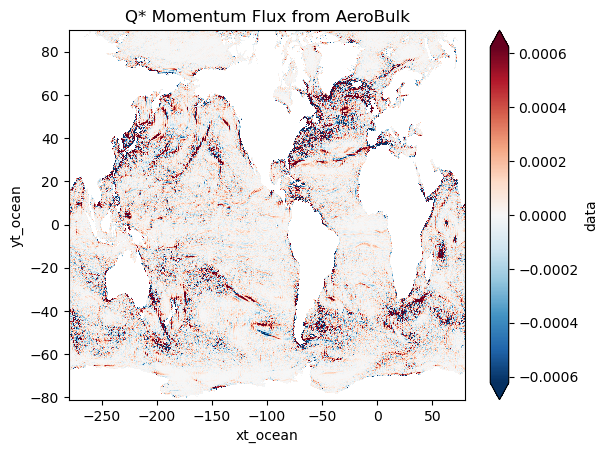

In [22]:
momfluxHR = np.sqrt( (taux ** 2 + tauy ** 2) )
momfluxHR_DS = momfluxHR.to_dataset(name='data')

print("Filtering model")
momfluxHR_smooth = filter_inputs_dataset(momfluxHR_DS, ['yt_ocean', 'xt_ocean'], filter_scale=4, filter_type='taper')
momfluxHR_smooth_DA = momfluxHR_smooth['data']

momfluxLR = np.sqrt( (taux_LR ** 2 + tauy_LR ** 2) )
momfluxLR_DS = momfluxLR.to_dataset(name='data')

print("Filtering model")
momfluxLR_smooth = filter_inputs_dataset(momfluxLR_DS, ['yt_ocean', 'xt_ocean'], filter_scale=4, filter_type='taper')
momfluxLR_smooth_DA = momfluxLR_smooth['data']

Mcbar = momfluxLR_smooth_DA
Mbar = momfluxHR_smooth_DA
Mbar_star = Mbar - Mcbar
Mbar_star.isel(time=0).plot(robust=True)
plt.title('Q* Momentum Flux from AeroBulk')

### Freshwater flux

Filtering model
Filtering model


Text(0.5, 1.0, 'Q* Freshwater Flux from AeroBulk')

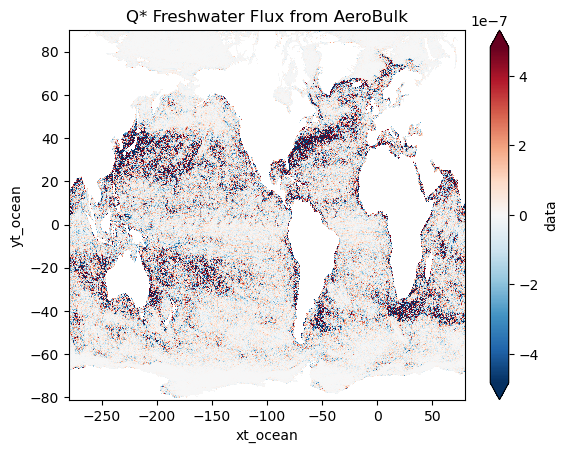

In [23]:
freshfluxHR = evap
freshfluxHR_DS = freshfluxHR.to_dataset(name='data')

print("Filtering model")
freshfluxHR_smooth = filter_inputs_dataset(freshfluxHR_DS, ['yt_ocean', 'xt_ocean'], filter_scale=4, filter_type='taper')
freshfluxHR_smooth_DA = freshfluxHR_smooth['data']

freshfluxLR = evap_LR
freshfluxLR_DS = freshfluxLR.to_dataset(name='data')

print("Filtering model")
freshfluxLR_smooth = filter_inputs_dataset(freshfluxLR_DS, ['yt_ocean', 'xt_ocean'], filter_scale=4, filter_type='taper')
freshfluxLR_smooth_DA = freshfluxLR_smooth['data']

Fcbar = freshfluxLR_smooth_DA
Fbar = freshfluxHR_smooth_DA
Fbar_star = Fbar - Fcbar
Fbar_star.isel(time=0).plot(robust=True)
plt.title('Q* Freshwater Flux from AeroBulk')

### Format heat flux data to compare against CM2.6 flux

In [33]:
Qstar = Qbar_star.mean(dim="xt_ocean").mean(dim="yt_ocean")
Qstar_year = Qstar.isel(time=slice(0,365))
Qmonth = Qstar_year.groupby('time.month').mean()
Qmonth

<xarray.DataArray 'data' (month: 12)> Size: 48B
dask.array<groupby_nanmean, shape=(12,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

# For fluxes calculated by CM2.6 -- some useful functions

In [34]:
def get_params(version:str, test:bool=True) -> dict[str, str]:
    bucket = 'gs://leap-persistent/jbusecke' # equivalent to os.environ['PERSISTENT_BUCKET'], but this should work for all collaborators
    scratch = 'gs://leap-scratch/jbusecke'
    suffix = 'test' if test else ''
    n_coarsen = 50
    project_path = f"scale-aware-air-sea"
    version_full = version+suffix
    global_params = {
        'filter_type':"gaussian",
        'filter_scale':50,
        'n_coarsen': n_coarsen,
        'version': version_full,
        'paths':{
            model:{
                    'preprocessing':
                        {
                            'scratch': f"{scratch}/{project_path}/{version_full}/temp/{model}.zarr"
                        },
                    'smoothing':
                        {
                        'filter': f"{bucket}/{project_path}/{version_full}/smoothing/{model}_filter.zarr",
                        'coarse': f"{bucket}/{project_path}/{version_full}/smoothing/{model}_coarse_{n_coarsen}.zarr",
                        },
                    'fluxes':
                        {
                        'filter':
                         {
                             'prod': f"{bucket}/{project_path}/{version_full}/fluxes/{model}_fluxes_filter_prod.zarr", 
                             'appendix': f"{bucket}/{project_path}/{version_full}/fluxes/{model}_fluxes_filter_appendix.zarr",
                         },
                         'coarse':
                         {
                            'prod': f"{bucket}/{project_path}/{version_full}/fluxes/{model}_fluxes_coarse_{n_coarsen}_prod.zarr",
                            'appendix': f"{bucket}/{project_path}/{version_full}/fluxes/{model}_fluxes_coarse_{n_coarsen}_appendix.zarr",
                         },
                         },
                 'results':
                 {
                    'filter':{
                         'native':{
                             'prod':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_filter_decomposed_native_prod.zarr",
                             'appendix':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_filter_decomposed_native_appendix.zarr",
                             'all_terms':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_filter_decomposed_native_all_terms.zarr",
                         },
                         'mean':{
                             'prod':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_filter_decomposed_mean_prod.zarr",
                             'appendix':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_filter_decomposed_mean_appendix.zarr",
                             'all_terms':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_filter_decomposed_mean_all_terms.zarr",
                         },
                     
                     },
                     'coarse':{
                         'native':{
                             'prod':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_coarse_decomposed_native_prod_{n_coarsen}.zarr",
                             'appendix':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_coarse_decomposed_native_appendix_{n_coarsen}.zarr",
                             'all_terms':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_coarse_decomposed_native_all_terms.zarr",
                         },
                         'mean':{
                             'prod':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_coarse_decomposed_mean_prod_{n_coarsen}.zarr",
                             'appendix':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_coarse_decomposed_mean_appendix_{n_coarsen}.zarr",
                             'all_terms':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_coarse_decomposed_mean_all_terms.zarr",
                         },
                     
                     },
                },
                'plotting':
                {
                    'max_ice_mask': f"{bucket}/{project_path}/{version_full}/plotting/{model}_max_ice_mask.zarr",
                    'full_fluxes':{ 
                        k: {
                            kk:f"{bucket}/{project_path}/{version_full}/plotting/{model}_full_flux_{k}_{kk}.zarr" for kk in ['global_mean', 'time_mean']
                        } for k in ['online', 'offline']
                    },
#                     'filter':{
#                          'native':{
#                              'prod':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_filter_decomposed_native_prod.zarr",
#                              'appendix':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_filter_decomposed_native_appendix.zarr",
#                              'all_terms':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_filter_decomposed_native_all_terms.zarr",
#                          },
#                          'mean':{
#                              'prod':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_filter_decomposed_mean_prod.zarr",
#                              'appendix':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_filter_decomposed_mean_appendix.zarr",
#                              'all_terms':f"{bucket}/{project_path}/{version_full}/results/{model}_fluxes_filter_decomposed_mean_all_terms.zarr",
#                          },
                     
#                      },
                },
            } for model in ['CM26','CESM']
        }
    }
    return global_params

In [35]:
def add_total(ds: xr.Dataset) -> xr.Dataset:
    ds["q_total"] = ds["ql"] + ds["qh"]
    return ds

In [36]:
label_dict = {
    "ql": "Latent Heatflux [$W/m^2$]",
    "qh": "Sensible Heatflux [$W/m^2$]",
    "q_total": "Turbulent Heatflux\n(Sensible + Latent) [$W/m^2$]",
}

# Finding fluxes computed in CM2.6

In [37]:
params = get_params("v1.0.1", test=False)
models = ["CM26", "CESM"]
open_kwargs = dict(
    engine="zarr",
    chunks={},
)

In [38]:
max_ice_mask = {}
path = params["paths"]["CM26"]["plotting"]["max_ice_mask"]
da = xr.open_dataset(path, **open_kwargs).max_extent_ice_mask
max_ice_mask["CM26"] = da

In [39]:
# full flux output
full_flux = {}
for model in models:
    full_flux[model] = {}
    for computed in ["online", "offline"]:
        full_flux[model][computed] = {}
        for mean in ["time_mean", "global_mean"]:
            path = params["paths"][model]["plotting"]["full_fluxes"][computed][mean]
            ds = xr.open_dataset(path, **open_kwargs)
            full_flux[model][computed][mean] = ds

In [ ]:
fig, ax = plt.subplots()

ds = full_flux["CM26"]["online"]["global_mean"]
da = add_total(ds)["q_total"]
da.plot(label="Online", ax=ax, lw=2, ls="--", color="k")

#ds_offline = full_flux["CM26"]["offline"]["global_mean"]
#da_offline = add_total(ds_offline)["q_total"]
#da_offline.sel(algo='ecmwf').plot(label=f"Offline ({'ecmwf'})", ax=ax)

Qmonth.plot(ax=ax)

ax.set_title("CM26")
ax.set_ylabel(label_dict["q_total"])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="best")
